In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.calibration import calibration_curve

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

In [4]:
f = pd.read_csv('C:\\df_data.csv')
df = pd.DataFrame(f)

# Scaling & Train-Test Split

In [5]:
y = df.pop('target')

In [6]:
X = df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=8)

In [8]:
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.transform(X_test)

In [9]:
X_train = pd.DataFrame(X_train_mm, columns=['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m', 
                                            'blue_collar', 'student', 'retiree', 'unemployed', 'illiterate',
                                            'unknown_edu', 'university', 'basic4','basic_other', 'single', 
                                            'no_default', 'age_retiree', 'age_student', 'age_basic4', 
                                            'age_illiterate', 'poutcome_nonexistent', 'poutcome_success', 
                                            'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 
                                            'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
                                            'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 
                                            'day_of_week_wed'])

In [10]:
X_test = pd.DataFrame(X_test_mm, columns=['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m', 
                                          'blue_collar', 'student', 'retiree', 'unemployed', 'illiterate',
                                          'unknown_edu', 'university', 'basic4','basic_other', 'single',
                                          'no_default', 'age_retiree', 'age_student', 'age_basic4', 
                                          'age_illiterate', 'poutcome_nonexistent', 'poutcome_success', 
                                          'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 
                                          'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
                                          'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 
                                          'day_of_week_wed'])

# Five Models

The **5 classification models** - Logistic regression, NaiveBayes, Random Forest, SVC and XGBoost - according to the Gridsearch tuned hyper-parameters

In [11]:
logit = LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000, penalty='l1', solver='liblinear', 
                           random_state=8)

In [12]:
gnb = GaussianNB(var_smoothing=0.0001, priors=None)

In [13]:
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_features='log2', min_samples_split=30, 
                            n_estimators=175, random_state=8)

In [14]:
svc = SVC(C=1000, kernel='rbf', gamma=0.01, class_weight='balanced', max_iter=200000, random_state=8)

In [15]:
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, 
                        colsample_bytree=1, eval_metric='logloss', gamma=10, gpu_id=-1, importance_type='gain', 
                        objective='binary:logistic', interaction_constraints='', learning_rate=0.1, 
                        max_delta_step=0, max_depth=6, min_child_weight=1, monotone_constraints='()', 
                        n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=8, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=5, seed=8, subsample=1, tree_method='exact',
                        validate_parameters=1, verbosity=None, use_label_encoder=False)

In [16]:
clf_dict = {
    'Logistic Regression': logit,
    'Naive Bayes': gnb, 
    'Random Forest': rf,
    'SV Classification': svc, 
    'XG Boost': xgb  
}

# Predicted Probabilities

Binary classification algorithms may return a matrix of **predicted probabilities** for class 0 and class 1 in that order. The interest is in **class 1, or "success"**. 

In [17]:
# Empty lists to be filled with the predicted probabilities
logit_prob = []
gnb_prob = []
rf_prob = []
svc_prob = []
xgb_prob = []

In [18]:
# Using only the training data (split above) for the calibration curve procedure, but need to split it further...
# into train-validation sets
X_train_cab, X_test_cab, y_train_cab, y_test_cab = train_test_split(X_train, y_train, 
                                                                    stratify=y_train, test_size=0.3, random_state=8)

C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


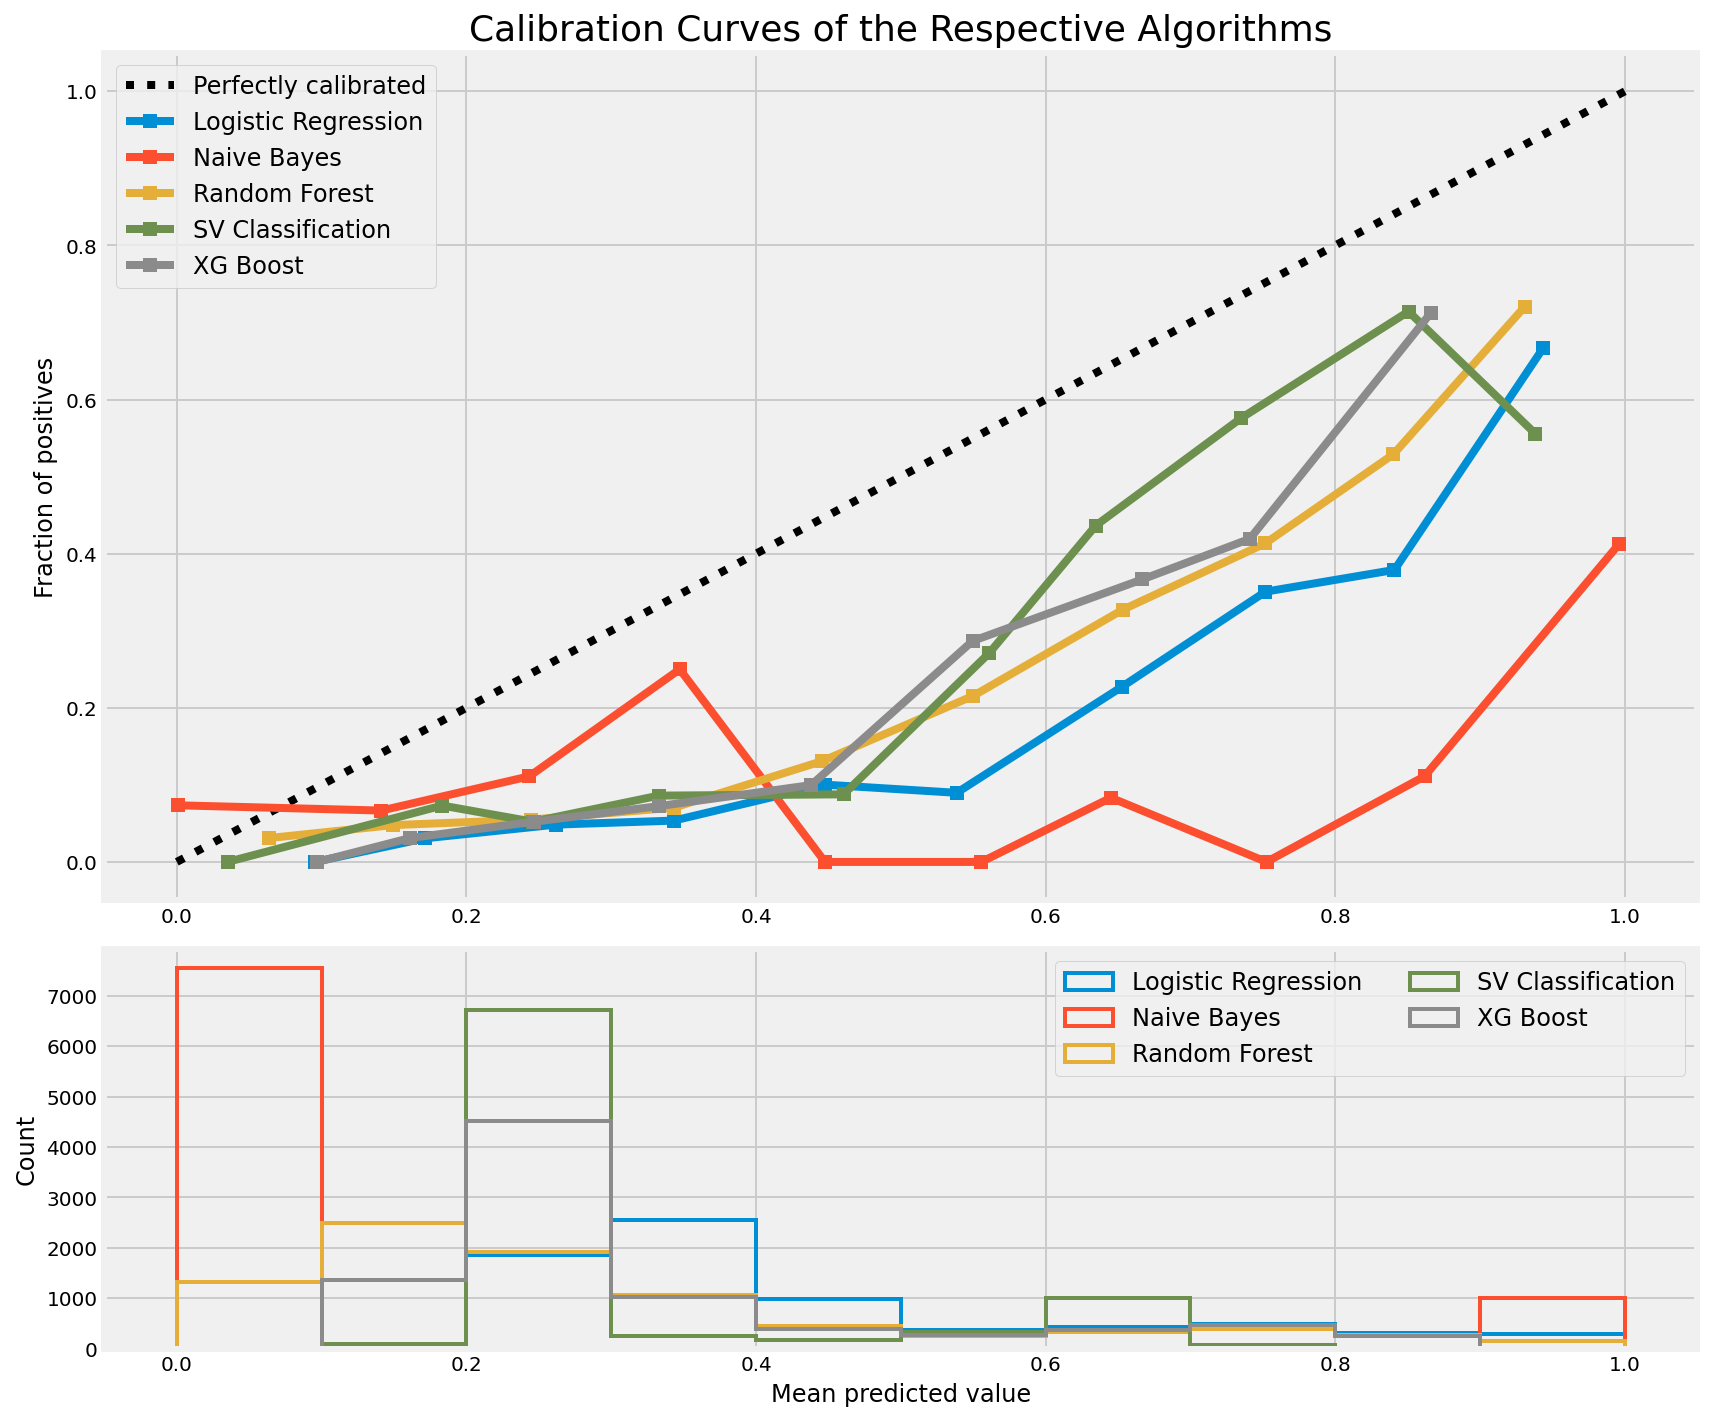

In [19]:
plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for key, clf in clf_dict.items():
    
    clf.fit(X_train_cab, y_train_cab)
    
    # Generating class=1 predicted probabilities
    if hasattr(clf, "predict_proba"):
        train_pos = clf.predict_proba(X_train_cab)[:, 1]
        test_pos = clf.predict_proba(X_test_cab)[:, 1]
    else:  # use decision function instead (eg SVC)
        train_pos = clf.decision_function(X_train_cab)
        train_pos = (train_pos - train_pos.min()) / (train_pos.max() - train_pos.min())        
        test_pos = clf.decision_function(X_test_cab)
        test_pos = (test_pos - test_pos.min()) / (test_pos.max() - test_pos.min())     
    
    if key == 'Logistic Regression':
        logit_prob.append(train_pos)
        logit_prob.append(test_pos)
    elif key == 'Naive Bayes':
        gnb_prob.append(train_pos)
        gnb_prob.append(test_pos)
    elif key == 'Random Forest':
        rf_prob.append(train_pos)
        rf_prob.append(test_pos)
    elif key == 'SV Classification':
        svc_prob.append(train_pos)
        svc_prob.append(test_pos)
    else:
        xgb_prob.append(train_pos)
        xgb_prob.append(test_pos)

    # Preparing calibration curves
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_cab, test_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (key, ))

    ax2.hist(test_pos, range=(0, 1), bins=10, label=key,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left", fontsize=12)
ax1.set_title('Calibration Curves of the Respective Algorithms', fontsize=18)

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper right", ncol=2, fontsize=12)

plt.tight_layout()
plt.show()

The probability calibration curve sorts the predicted probabilities of class 1 in the target variable. It then bins the probabilities (according to 10 bins in this case) and calculates the **mean of the predicted probabilities** in each bin. It also calculates the percentage of **actual class 1 observations** in each bin

The percentage of class 1 in each bin that is actually in class 1 of the target variable. This is determined by looking at what values these points are actually assigned in y compared to the emperical truth.

Accurate **predicted probabilities** would be expected to line up closely to the **actual percentage of class 1 observations** in each bin. This would be consistent with the theoretical "perfectly calibrated" line. Otherwise the two probabilities will diverge, which is what we see in this case.

**All five algorithms show sizeable divergences from the "perfectly calibrated" line**. This means that the predicted probability output need to be **calibrated** first.

# Comparative Probability Distributions

In [20]:
logit_prob

[array([0.3323867 , 0.34222108, 0.4684644 , ..., 0.36016146, 0.69616134,
        0.15466413]),
 array([0.29359072, 0.77182363, 0.32968679, ..., 0.89120606, 0.90080362,
        0.30168689])]

In [21]:
# Combining the respective predicted probabilities into a DF
pred_probabilities = pd.DataFrame(
    {'logit': [j for i in logit_prob for j in i], # Need to flatten the two Numpy arrays in each list
     'gnb': [j for i in gnb_prob for j in i],
     'rf': [j for i in rf_prob for j in i],
     'svc': [j for i in svc_prob for j in i],
     'xgb': [j for i in xgb_prob for j in i]
    })

In [22]:
# Predicted probabilities from uncalibrated training set
pred_probabilities

,logit,gnb,rf,svc,xgb
0,0.332387,8.233660e-06,0.368407,0.162993,0.262944
1,0.342221,1.371534e-05,0.065779,0.160387,0.224218
2,0.468464,3.018643e-05,0.628461,0.248009,0.537540
3,0.952151,1.000000e+00,0.965629,0.488322,0.877798
4,0.784860,1.519641e-04,0.819912,0.478780,0.700599
...,...,...,...,...,...
28818,0.788120,1.385100e-04,0.691756,0.617876,0.697288
28819,0.264071,4.748608e-08,0.124997,0.236917,0.229310
28820,0.891206,1.000000e+00,0.839679,0.657680,0.785038
28821,0.900804,1.000000e+00,0.759461,0.628527,0.736368


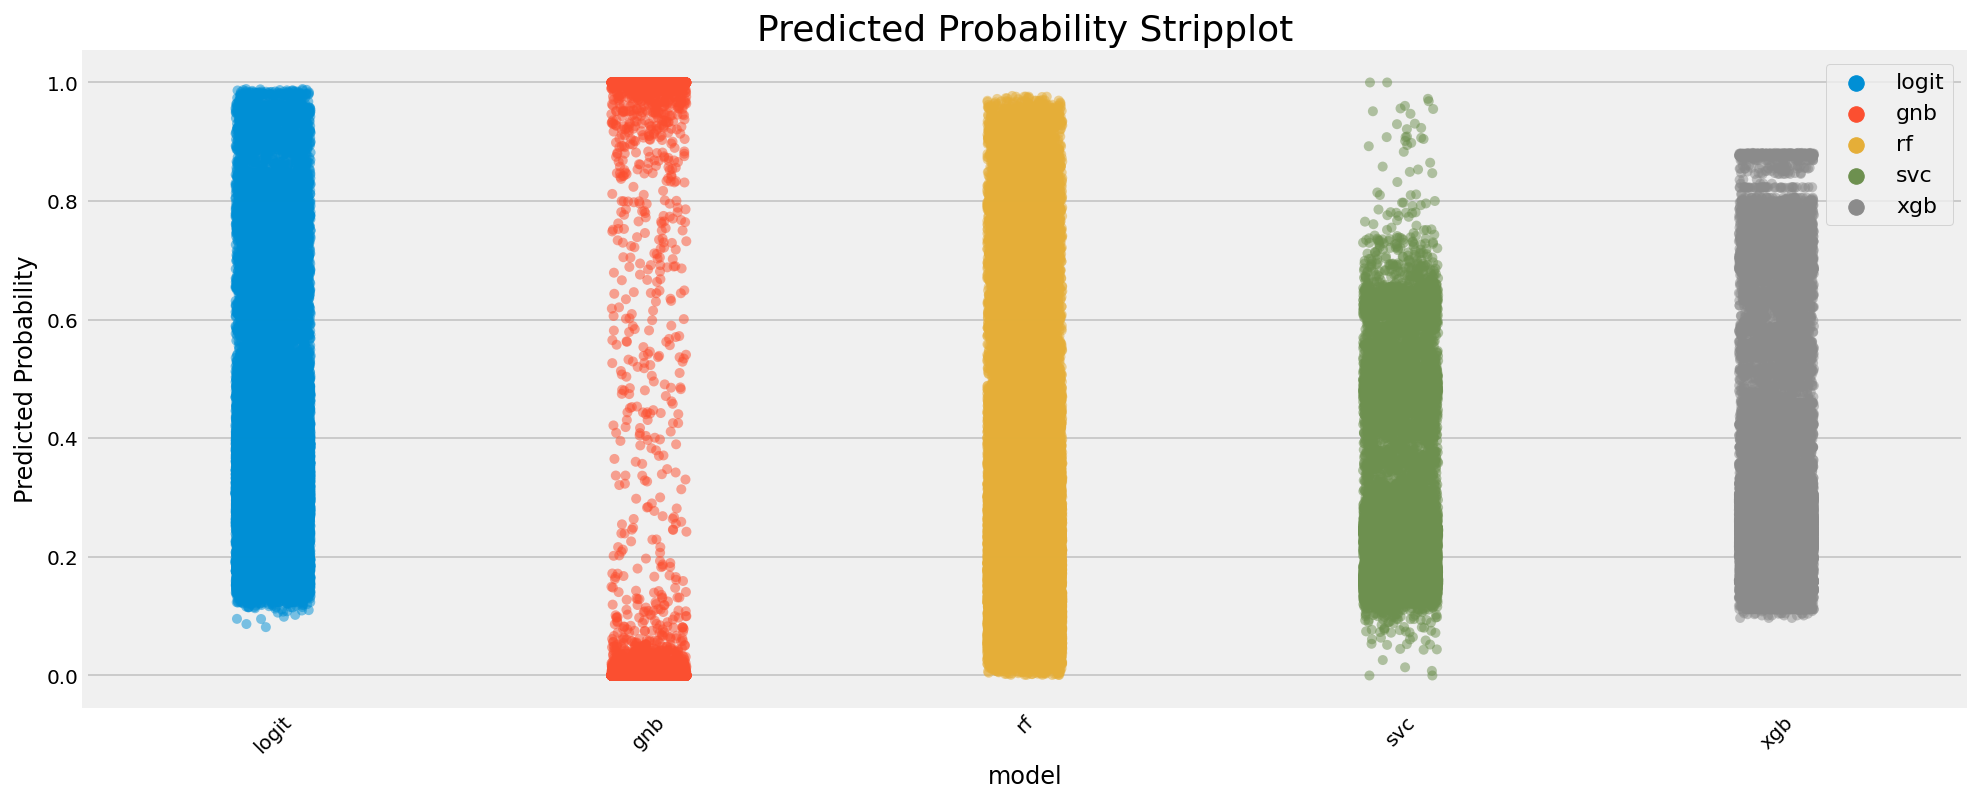

In [23]:
# Certain clusters of neighbourhoods do share similar distributions of 'SalePrice' and/or 'PriceSF'
fig, ax = plt.subplots(figsize=(15,6))

df_melt = pd.melt(pred_probabilities, var_name='model', value_name='probabilities')
sns.stripplot(x='model', y='probabilities', data=df_melt, hue='model', jitter=0.1, alpha=0.5, ax=ax)

ax.set_ylabel("Predicted Probability")
ax.legend(loc="upper right", fontsize=11)
ax.set_ylim([-0.05, 1.05])
plt.title('Predicted Probability Stripplot', fontsize=18)
plt.xticks(rotation=45)
plt.show()

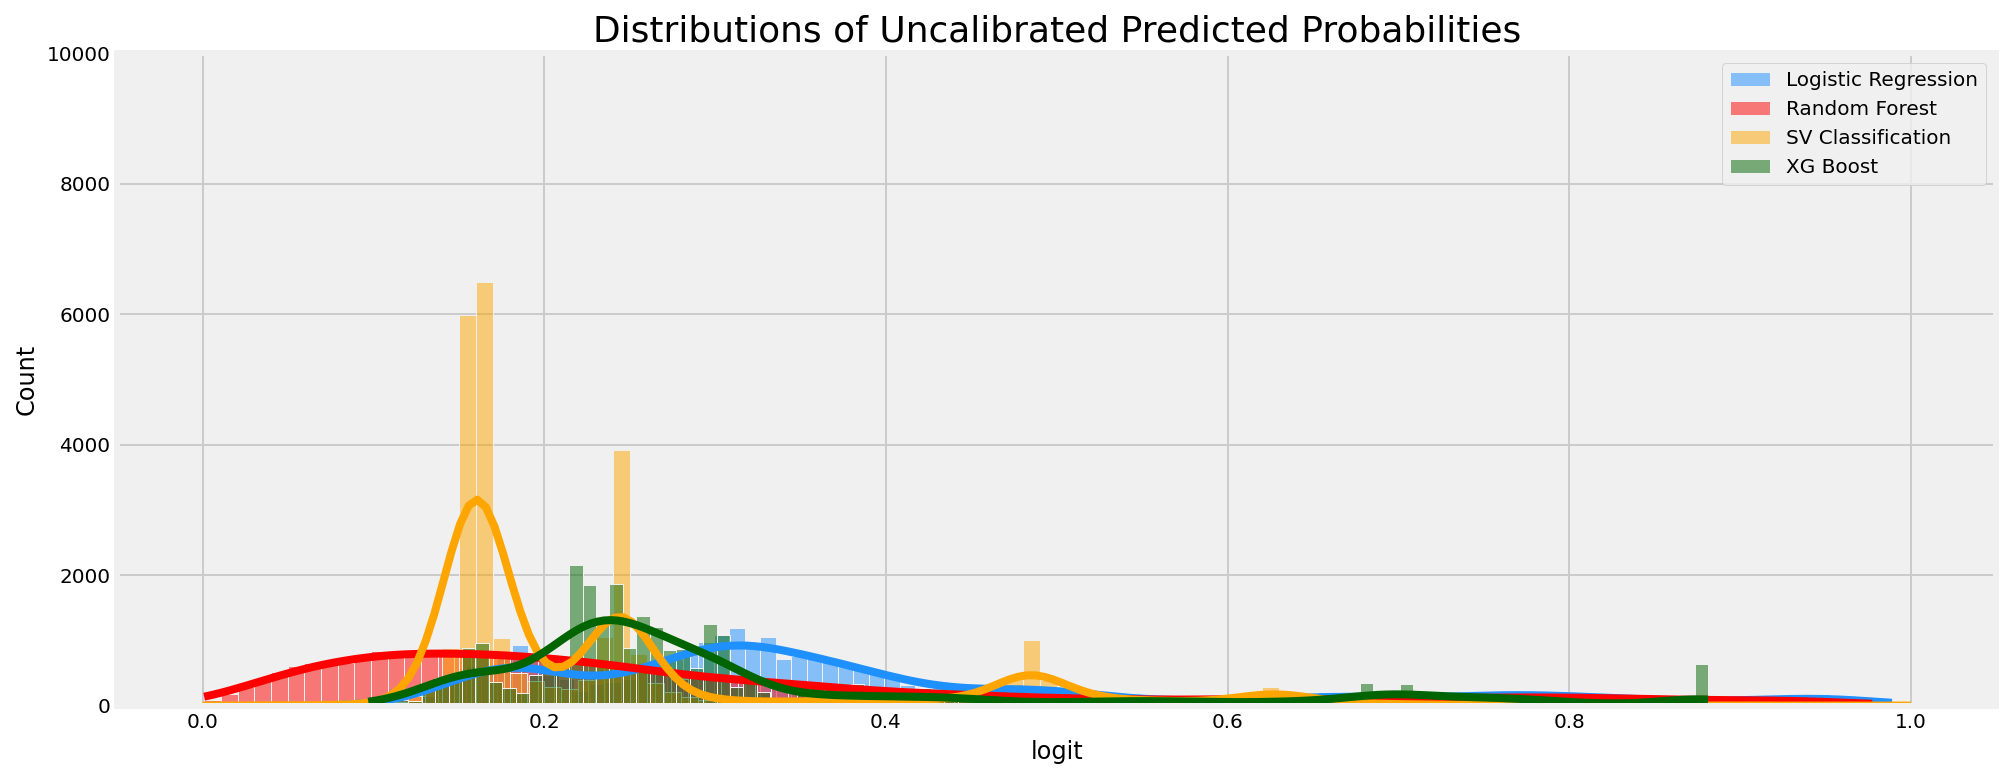

In [24]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(pred_probabilities['logit'], bins=100, kde=True, ax=ax, color='dodgerblue', label='Logistic Regression')
#sns.histplot(pred_probabilities['gnb'], bins=100, kde=True, ax=ax, color='gray', label='Naive Bayes')
sns.histplot(pred_probabilities['rf'], bins=100, kde=True, ax=ax, color='red', label='Random Forest')
sns.histplot(pred_probabilities['svc'], bins=100, kde=True, ax=ax, color='orange', label='SV Classification')
sns.histplot(pred_probabilities['xgb'], bins=100, kde=True, ax=ax, color='darkgreen', label='XG Boost')

ax.yaxis.set_ticks(np.arange(0.00, 11000, 2000))
ax.legend(loc="center", fontsize=12)
plt.title('Distributions of Uncalibrated Predicted Probabilities', fontsize=18)
plt.legend();

# Fitting Optimal Models on Training Data

In [25]:
f1_scorer = make_scorer(f1_score)

In [26]:
# Must use stratified kFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3)

In [27]:
logit.fit(X_train, y_train)
y_hat_train_lr = logit.predict(X_train)
y_hat_test_lr = logit.predict(X_test)
scores_lr = cross_val_score(logit, X_train, y_train, scoring=f1_scorer, cv=kf)

print("Logit CV F1 scores:", scores_lr)
print("Logit mean CV score:", np.mean(scores_lr))

Logit CV F1 scores: [0.43519098 0.43785851 0.42726412]
Logit mean CV score: 0.4334378709571261


In [28]:
gnb.fit(X_train, y_train)
y_hat_train_gnb = gnb.predict(X_train)
y_hat_test_gnb = gnb.predict(X_test)
scores_gnb = cross_val_score(gnb, X_train, y_train, scoring=f1_scorer, cv=kf)

print("NB CV F1 scores:", scores_gnb)
print("NB mean CV score:", np.mean(scores_gnb))

NB CV F1 scores: [0.40053884 0.41958042 0.40480427]
NB mean CV score: 0.408307843844616


In [29]:
rf.fit(X_train, y_train)
y_hat_train_rf = rf.predict(X_train)
y_hat_test_rf = rf.predict(X_test)
scores_rf = cross_val_score(rf, X_train, y_train, scoring=f1_scorer, cv=kf)

print("RF CV F1 scores:", scores_rf)
print("RF mean CV score:", np.mean(scores_rf))

RF CV F1 scores: [0.49550225 0.50114068 0.48568156]
RF mean CV score: 0.494108163710905


In [30]:
svc.fit(X_train, y_train)
y_hat_train_svc = svc.predict(X_train)
y_hat_test_svc = svc.predict(X_test)
scores_svc = cross_val_score(svc, X_train, y_train, scoring=f1_scorer, cv=kf)

print("SVC CV F1 scores:", scores_svc)
print("SVC mean CV score:", np.mean(scores_svc))

C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC CV F1 scores: [0.47524047 0.47807333 0.47318841]
SVC mean CV score: 0.47550073486355293


In [31]:
xgb.fit(X_train, y_train)
y_hat_train_xgb = xgb.predict(X_train)
y_hat_test_xgb = xgb.predict(X_test)
scores_xgb = cross_val_score(xgb, X_train, y_train, scoring=f1_scorer, cv=kf)

print("XGB CV F1 scores:", scores_xgb)
print("XGB mean CV score:", np.mean(scores_xgb))

XGB CV F1 scores: [0.49315068 0.51280032 0.49542744]
XGB mean CV score: 0.5004594784679534


The **mean CV scores** above confirm the scores obtained in the GridsearchCV in the **second file**.

# Comparative Test Scoring

In [32]:
# Dictionary of fitted classifiers taken from above
fitted_dict = {
    'Logistic Regression': logit,
    'Naive Bayes': gnb, 
    'Random Forrest': rf,
    'SV Classification': svc, 
    'XG Boost' : xgb   
}

In [33]:
def batch_clf(X_train, y_train, X_test, y_test, dictionary, verbose=True):
    '''
    Loops through dictionary of fitted models, tests them and returns metrics
    '''
    train_f1_scores = []
    test_f1_scores = []
    train_cohen_scores = []
    test_cohen_scores = []
    train_pre_scores = []
    test_pre_scores = []
    train_acc_scores = []
    test_acc_scores = []
    
    # Loop through dictionary of fitted models:
    for key, clf in dictionary.items():
        
        # Get predictions
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        
        #Get F1 scores
        train_f1 = f1_score(y_train, train_preds, average='binary')
        train_f1_scores.append(round(train_f1, 4))
        test_f1 = f1_score(y_test, test_preds, average='binary')
        test_f1_scores.append(round(test_f1, 4))
        
        # Get Cohen's kappa
        train_cohen = cohen_kappa_score(y_train, train_preds)
        train_cohen_scores.append(round(train_cohen, 4))
        test_cohen = cohen_kappa_score(y_test, test_preds)
        test_cohen_scores.append(round(test_cohen, 4))
        
        # Get AUC of precision-recall curves
        train_pre = average_precision_score(y_train, train_preds, average='macro')
        train_pre_scores.append(round(train_pre, 4))
        test_pre = average_precision_score(y_test, test_preds, average='macro')
        test_pre_scores.append(round(test_pre, 4))           
                
        #Get accuracy scores
        train_acc = accuracy_score(y_train, train_preds)
        train_acc_scores.append(round(train_acc,4))
        test_acc = accuracy_score(y_test, test_preds)
        test_acc_scores.append(round(test_acc,4))
        
    # Create results dataframe
    results = pd.DataFrame({'Model': list(dictionary.keys()), 
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            "Train Cohen's kappa" : train_cohen_scores,
                            "Test Cohen's kappa" : test_cohen_scores,
                            'Train PR-AUC': train_pre_scores,
                            'Test PR-AUC': test_pre_scores,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores,
                            })

    return results

In [34]:
results = batch_clf(X_train, y_train, X_test, y_test, fitted_dict)
results

,Model,Train F1,Test F1,Train Cohen's kappa,Test Cohen's kappa,Train PR-AUC,Test PR-AUC,Train Accuracy,Test Accuracy
0,Logistic Regression,0.4341,0.4377,0.3353,0.3394,0.2507,0.2537,0.8126,0.8132
1,Naive Bayes,0.4080,0.4040,0.3294,0.3225,0.2315,0.2278,0.8610,0.8560
2,Random Forrest,0.5706,0.4913,0.5031,0.4124,0.3718,0.2947,0.8781,0.8583
3,SV Classification,0.4809,0.4759,0.3982,0.3923,0.2862,0.2820,0.8501,0.8485
4,XG Boost,0.5162,0.5050,0.4439,0.4311,0.3168,0.3067,0.8712,0.8683


**All** five models saw improvements in their test **F1, Cohen's kappa and PR-AUC scores** after the Gridsearch fine-tuning.

Particularly **sizeable improvements** in the test scores for the **XG Boost** and **Random Forest** models. On the other hand, there were only slight improvements to the **Logistic Regression** and **Naive Bayes** models. **SVC** was in the middle in terms of improved test scores.

# Confusion Matrices

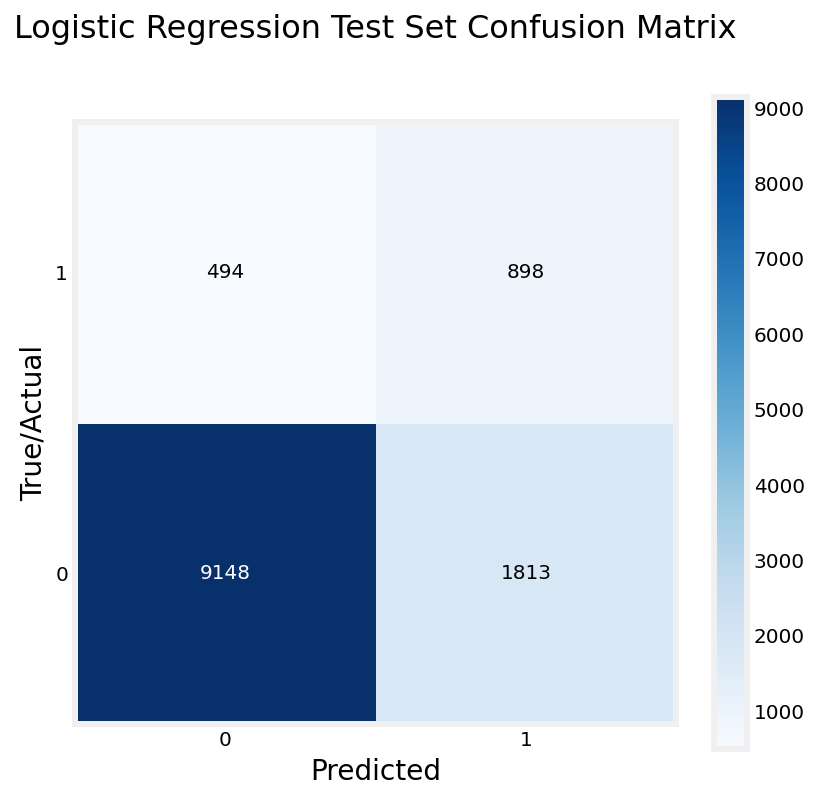

In [35]:
# Logit confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_lr, figsize=(6,6))
plt.title('Logistic Regression Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [36]:
print(metrics.classification_report(y_test, y_hat_test_lr))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10961
           1       0.33      0.65      0.44      1392

    accuracy                           0.81     12353
   macro avg       0.64      0.74      0.66     12353
weighted avg       0.88      0.81      0.84     12353



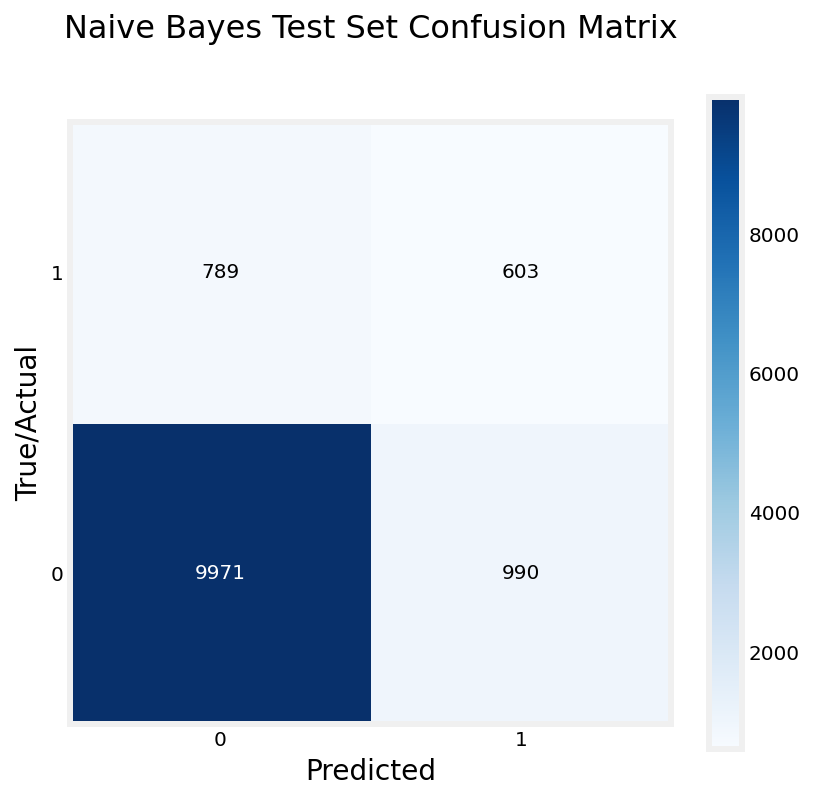

In [37]:
# NB confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_gnb, figsize=(6,6))
plt.title('Naive Bayes Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [38]:
print(metrics.classification_report(y_test, y_hat_test_gnb))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10961
           1       0.38      0.43      0.40      1392

    accuracy                           0.86     12353
   macro avg       0.65      0.67      0.66     12353
weighted avg       0.86      0.86      0.86     12353



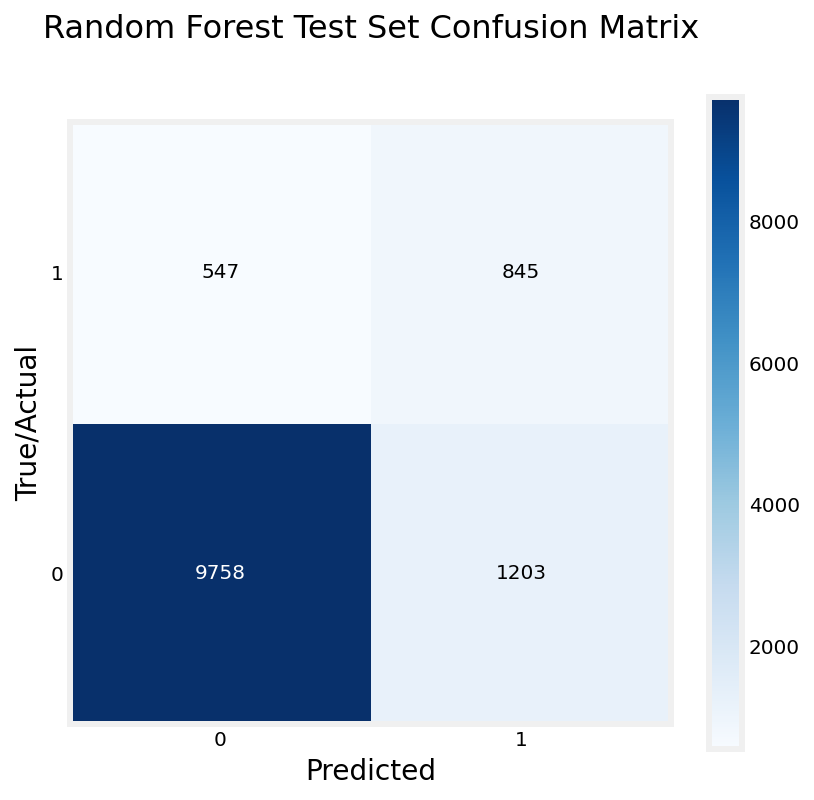

In [39]:
# RF confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_rf, figsize=(6,6))
plt.title('Random Forest Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [40]:
print(metrics.classification_report(y_test, y_hat_test_rf))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     10961
           1       0.41      0.61      0.49      1392

    accuracy                           0.86     12353
   macro avg       0.68      0.75      0.70     12353
weighted avg       0.89      0.86      0.87     12353



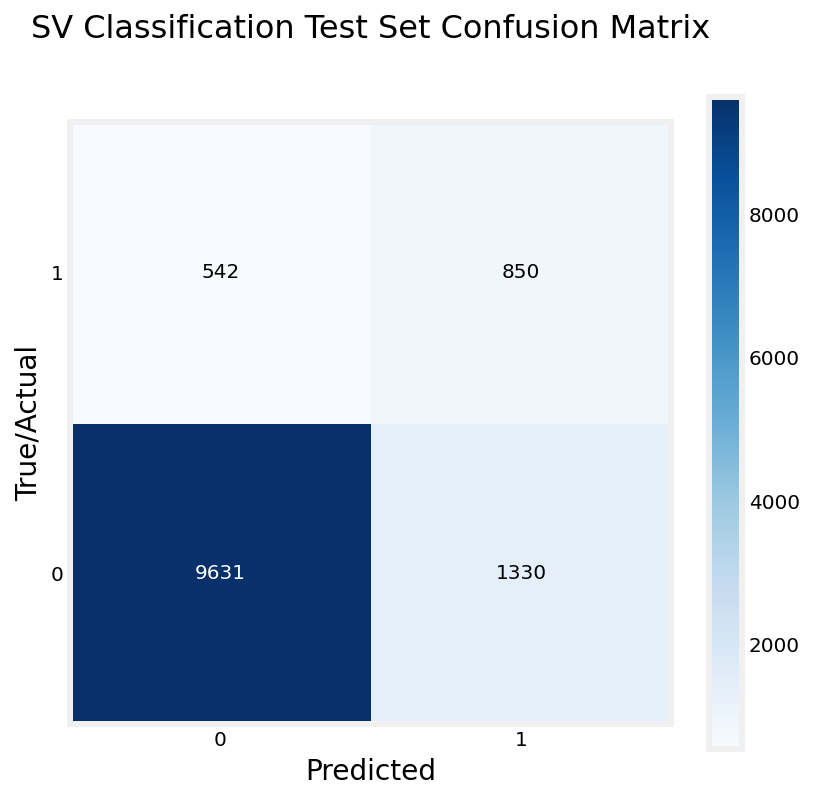

In [41]:
# SVC confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_svc, figsize=(6,6))
plt.title('SV Classification Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [42]:
print(metrics.classification_report(y_test, y_hat_test_svc))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10961
           1       0.39      0.61      0.48      1392

    accuracy                           0.85     12353
   macro avg       0.67      0.74      0.69     12353
weighted avg       0.88      0.85      0.86     12353



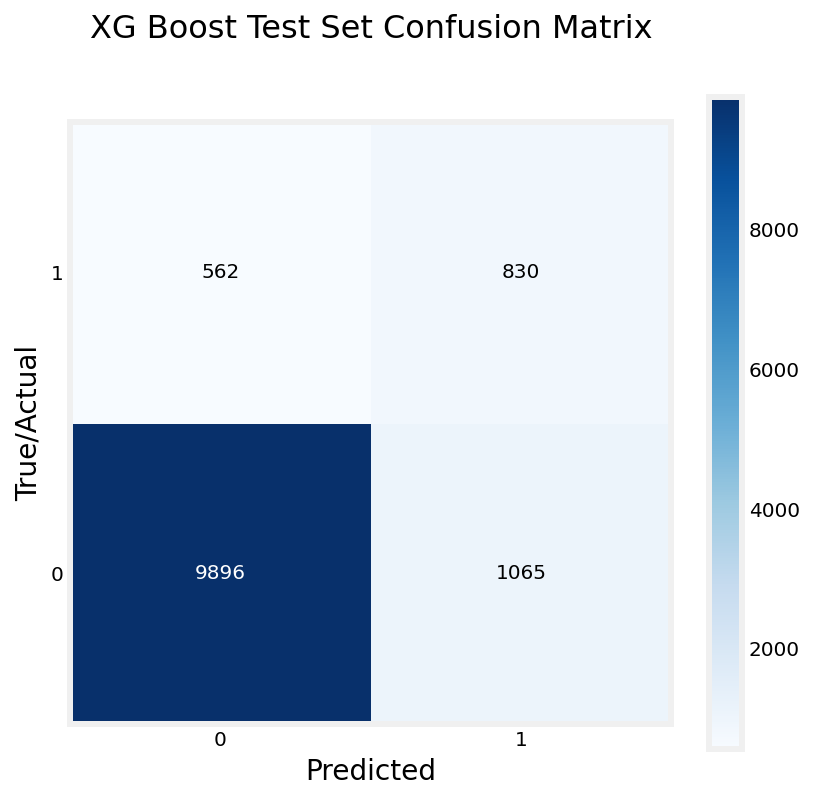

In [43]:
# XGB confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_xgb, figsize=(6,6))
plt.title('XG Boost Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [44]:
print(metrics.classification_report(y_test, y_hat_test_xgb))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     10961
           1       0.44      0.60      0.51      1392

    accuracy                           0.87     12353
   macro avg       0.69      0.75      0.71     12353
weighted avg       0.89      0.87      0.88     12353



The details of the individual confusion matrices are revealing. **Logit has the best recall rate by far at 0.65%**, but also the **lowest precision rate of 0.33**.

**XGB by constrast has the highest precision rate of 0.44, but ranked fourth in terms of the recall rate of 0.60** (though it is not much different from the tied 2nd and 3rd ranking scores).

Even though **XGB had the highest F1, Cohen's kappa and PR-AUC scores**, its is more of an all-rounder performer compared to **Logit, which is the better model if there is a preference for the recall rate** relative to precision.

Now we turn to examine the **predicted probabilities** given by these models.

# Logistic Regression Calibration Curve

In [45]:
Y_pp = pd.DataFrame(logit.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,0.658861,0.341139
1,0.847110,0.152890
2,0.633512,0.366488
3,0.703303,0.296697
4,0.840405,0.159595


In [46]:
y_prob_predict_logit = logit.predict_proba(X_test)[:, 1] # class 1 probabilities' column
logit_fraction_pos, logit_mean_predicted_value = calibration_curve(y_test, y_prob_predict_logit, n_bins=10)

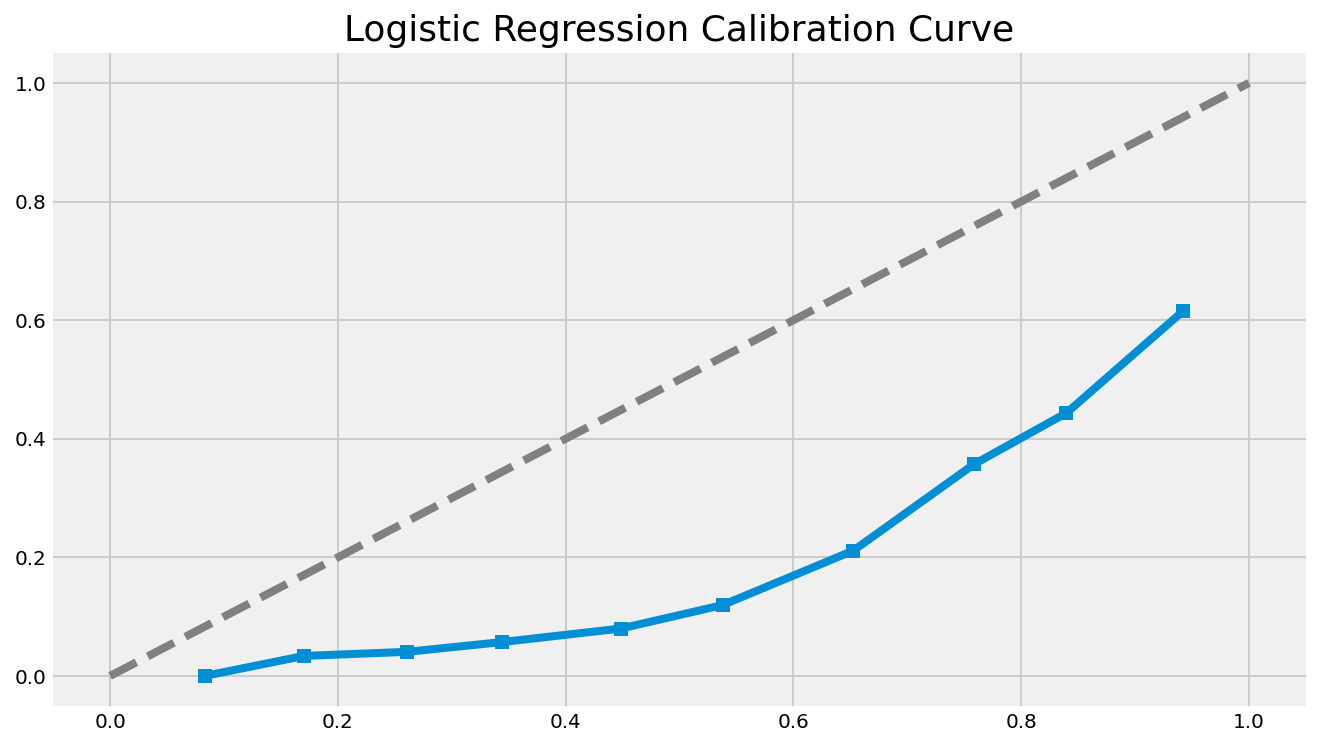

In [47]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.plot(logit_mean_predicted_value, logit_fraction_pos, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("Logistic Regression Calibration Curve", fontsize=18); pass

### The analysis is continued in the fourth file of the series